# No z-dependency - Schechter (MCMC) -GMM comparison

In [1]:
import copy
import os
#from nflows import transforms, distributions, flows
import torch
from scipy.special import logsumexp
from scipy.optimize import curve_fit
from scipy import integrate

from torch import nn
from torch import optim
import torch.distributions as D
import emcee
import corner
import time
from multiprocessing import cpu_count, Pool

import os
import h5py 
import numpy as np
# import fitsio
# from tqdm.auto import trange
import astropy.table as aTable
from astropy.cosmology import Planck13
from astropy.cosmology import FlatLambdaCDM

In [2]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
# mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

### Methods

#### Mass completeness limit

In [3]:
def mass_completeness_limit(z):
    f, b, c = [-1.34199453, 13.90578909,  8.53522654]
    return 4*np.pi*f*z**2 + b*z + c

#### Mass completeness limit inverse

In [4]:
def zmax_mass_completeness_limit(m):
    f, b, c = [-1.34199453, 13.90578909, 8.53522654]

    discriminant = -16*np.pi*f*c + 16*np.pi*f*m + b**2
    sqrt_discriminant = np.sqrt(discriminant)

    z1 = (-b + sqrt_discriminant) / (8 * np.pi * f)
    
    return z1

#### Selecting data (TODO polish)

In [5]:
def gathering_data(data, zmin, zmax):

    bgs = data
    mask_zlim = (bgs['Z_HP'].data > zmin) & (bgs['Z_HP'].data < zmax)
    
    z_tot = bgs['Z_HP'].data[mask_zlim]
    x_tot = bgs['provabgs_logMstar'].data[mask_zlim]
    x_median_tot = np.median(x_tot, axis=1)
    w_zfail_tot = bgs['provabgs_w_zfail'].data[mask_zlim]
    w_fib_tot = bgs['provabgs_w_fibassign'].data[mask_zlim]
    vmax_tot = bgs['Vmax'].data[mask_zlim]
    
    
    mass_comp_lim = mass_completeness_limit(z_tot)
    # mask_mlim = []
    # for i in range(len(x_median_tot)):
    #     mask_mlim.append(x_median_tot[i] > mass_comp_lim[i])
    mask_mlim = x_median_tot > mass_completeness_limit(z_tot)
        
    
    mask = (w_zfail_tot > 0) & (mask_mlim)
    
    z = z_tot[mask].astype(np.float32)
    x = x_tot[mask].astype(np.float32)
    x_median = x_median_tot[mask].astype(np.float32)
    w_zfail = w_zfail_tot[mask].astype(np.float32)
    w_fib = w_fib_tot[mask].astype(np.float32)
    vmax = vmax_tot[mask].astype(np.float32)
    
    
    f_area = (173.641/(4.*np.pi*(180/np.pi)**2))
    v_zmin = Planck13.comoving_volume(0.01).value * Planck13.h**3 * f_area # (Mpc/h)^3
    v_zmax = Planck13.comoving_volume(0.09).value * Planck13.h**3 * f_area # (Mpc/h)^3
    v_sub = v_zmax - v_zmin
    
    
    # w_spec * 1/Vmax
    w = (w_zfail*w_fib) * v_sub / (vmax.clip(v_zmin, v_zmax) - v_zmin)
    n = np.sum(w)/v_sub
    
    # Spectroscopic weights
    w_spec = (w_zfail*w_fib)

    return z, x, x_median, w_spec, vmax, v_zmax, v_zmin

#### Schechter function (no redshift dependence)

In [6]:
# For Emcee fit
def smf_single_schechter_sty(x, logM, alpha1):
    term0 = np.exp(-10 ** (x-logM))
    term1 = 10 ** ((alpha1+1)*(x - logM))
    return term0 * term1


# def smf_single_schechter_sty(x, logM, alpha1):
    
#     term0 = np.exp(-10 ** (x-logM[:,None]))
#     term1 = 10 ** ((alpha1+1)[:,None]*(x - logM[:,None]))
#     return term0 * term1

#### Log Likelihood - prior - posterior

In [7]:
def log_likelihood(logM, alpha1, w, x, z):
    I = []
    mlim = mass_completeness_limit(z)
    for i in range(z.shape[0]):
        I.append(integrate.quad(smf_single_schechter_sty, mlim[i], 13., args=(logM, alpha1))[0])
    q = smf_single_schechter_sty(x, logM, alpha1)
    a = np.log10(np.sum(q, axis=1)) - np.log10(I)
    return a * w


def log_prior(theta):
    logM, alpha1 = theta
    if 9.5 < logM < 13.5 and \
        -5. < alpha1 < 0. :
        return 0
    return -np.inf



def posterior(theta, w, x, z):
    logM, alpha1 = theta
    l = log_likelihood(logM, alpha1, w, x, z)
    return log_prior(theta) + np.sum(l)

#### Normalisation

In [8]:
def v_tot(f_area, z):
    v_min = Planck13.comoving_volume(0.01).value * Planck13.h**3 * f_area
    v_max = Planck13.comoving_volume(z).value * Planck13.h**3 * f_area
    return v_max  - v_min



def normalisation(f_area, w_spec, vmax, v_zmin, z, best_params):
    logM, alpha1 = best_params
    
    I = []
    mlim = mass_completeness_limit(z)
    for i in range(z.shape[0]):
        I.append(integrate.quad(smf_single_schechter_sty, mlim[i], 13., args=(logM, alpha1))[0])
    
    # return (1/v_tot(f_area,z0))* np.sum(w_spec/np.array(I)) THIS IS THE ONE FROM THE PAPER
    return np.sum(w_spec/np.array(I)/(vmax-v_zmin)), I



def v_tot2(f_area, zmin, zmax):
    v_min = Planck13.comoving_volume(zmin).value * Planck13.h**3 * f_area
    v_max = Planck13.comoving_volume(zmax).value * Planck13.h**3 * f_area
    return v_max  - v_min



def normalisation2(f_area, zmin, zmax, w_spec):
    logM, alpha1 = best_params
    
    I = []
    mlim = mass_completeness_limit(z)
    for i in range(z.shape[0]):
        I.append(integrate.quad(smf_single_schechter_sty, mlim[i], 13., args=(logM, alpha1))[0])
    
    return (1/v_tot2(f_area, zmin, zmax))* np.sum(w_spec/np.array(I))

#### Gaussian Mixture Model

In [9]:
class GaussianMixtureModel(nn.Module):
    def __init__(self, n_components: int=2, mmin=7., mmax=13.):
        super().__init__()
        logweights = torch.zeros(n_components, )
        means   = (mmax-mmin)*torch.rand(n_components, ) + mmin
        logstdevs  = 0.1*torch.tensor(np.random.uniform(size=n_components)) - 1.
        
        self.logweights = torch.nn.Parameter(logweights)
        self.means   = torch.nn.Parameter(means)
        self.logstdevs  = torch.nn.Parameter(logstdevs)
    
    def forward(self, x):
        mix  = D.Categorical(torch.exp(self.logweights))
        comp = D.Normal(self.means, torch.exp(self.logstdevs))
        gmm  = D.MixtureSameFamily(mix, comp)
        return - gmm.log_prob(x).mean()
    
    def log_prob(self, x): 
        mix  = D.Categorical(torch.exp(self.logweights))
        comp = D.Normal(self.means, torch.exp(self.logstdevs))
        gmm  = D.MixtureSameFamily(mix, comp)
        return gmm.log_prob(x)
    
    def sample(self, N):
        mix  = D.Categorical(torch.exp(self.logweights))
        comp = D.Normal(self.means, torch.exp(self.logstdevs))
        gmm  = D.MixtureSameFamily(mix, comp)
        
        return gmm.sample(N)

### Directories and Files to load

In [10]:
data_dir = '/Users/federico/OneDrive - University College London/PhD/PhD_project/bgs_psmf/data'
emcee_runs_dir = '/Users/federico/OneDrive - University College London/PhD/PhD_project/bgs_psmf/emcee_runs/bin_tests_runs'
gmm_dir = '/Users/federico/OneDrive - University College London/PhD/PhD_project/bgs_psmf/gmm'

data_file = 'BGS_ANY_full.provabgs.lite.hdf5'

## Selecting data

In [11]:
path_to_data = os.path.join(data_dir,data_file)

bgs = aTable.Table.read(path_to_data)
is_bgs_bright = bgs['is_bgs_bright']
is_bgs_faint = bgs['is_bgs_faint']

bgs = bgs[bgs['is_bgs_bright']]
f_area = (173.641/(4.*np.pi*(180/np.pi)**2))


## Emcee - GMM comparison

/var/folders/7q/qq4djnwd45n6znblnxh0t64m0000gn/T/ipykernel_10584/2300471932.py:28: RuntimeWarning: divide by zero encountered in divide
  w_import = (v_zmax - v_zmin) / (bgs['Vmax'].data.clip(v_zmin, v_zmax) - v_zmin)


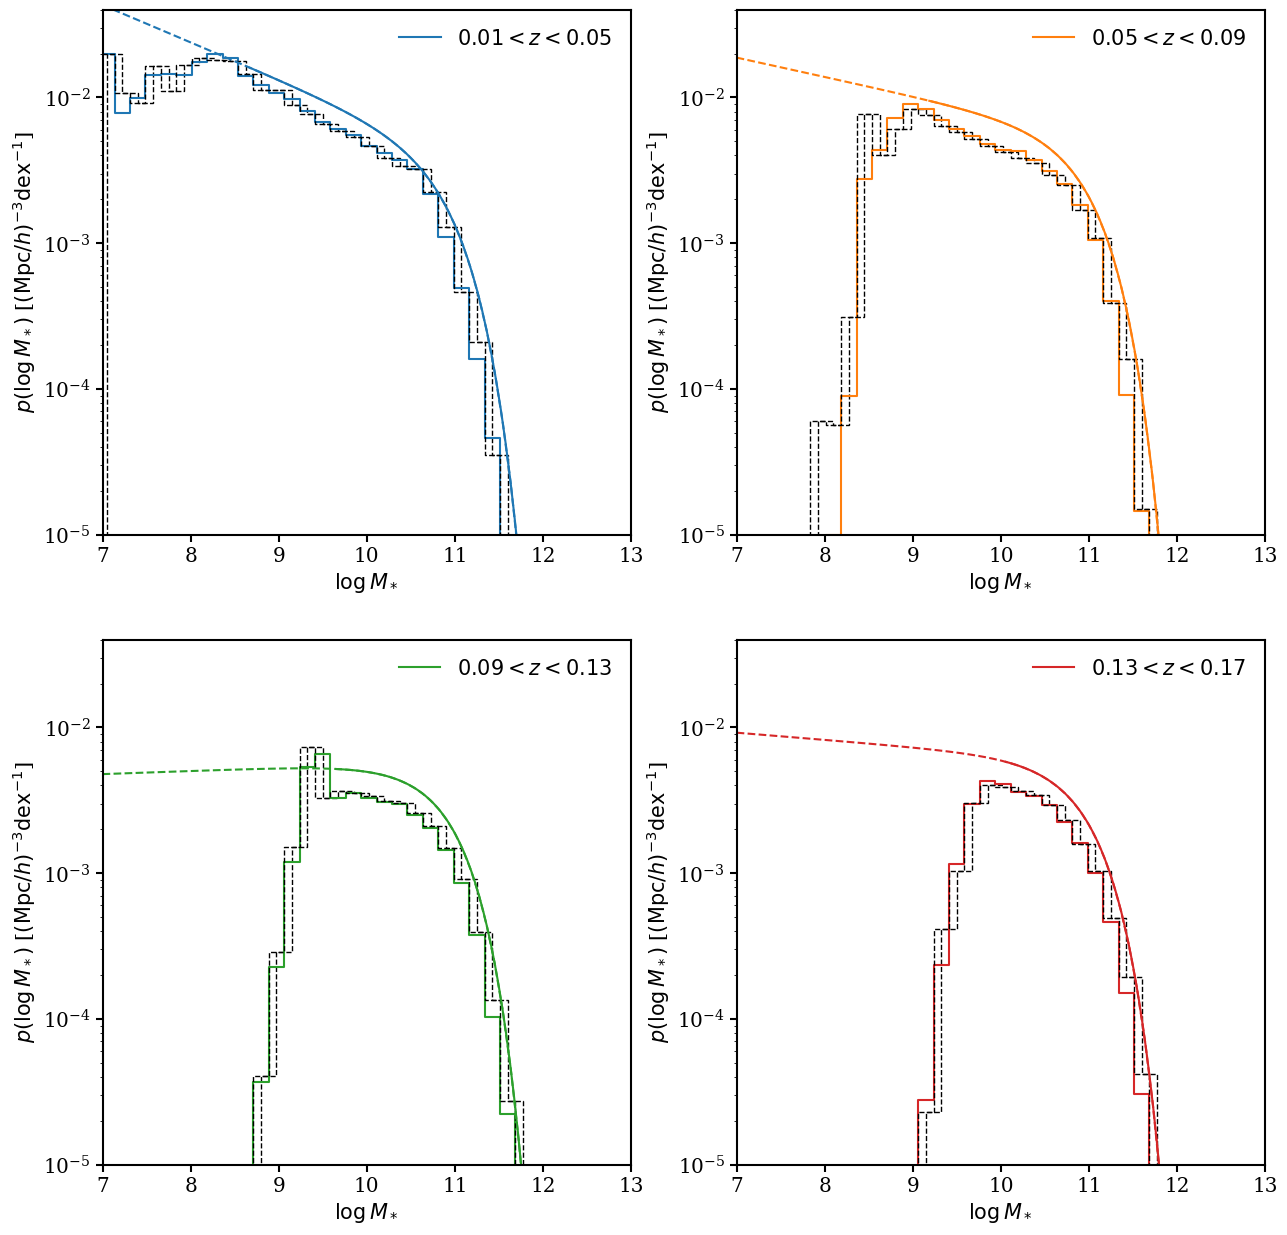

In [12]:
_zmin, _zmax, mlim = np.loadtxt(os.path.join(data_dir, 'psmf.logmstar_comp_limit.dat'), unpack=True, usecols=[0, 1, 2])

zmins = np.array([0.01 + 0.04 * i for i in range(4)])
zmaxs = np.array([0.05 + 0.04 * i for i in range(4)])

if torch.cuda.is_available():
    device = torch.device(type='cuda', index=0)
else:
    device = 'cpu'


x_lin_ext = np.linspace(7, 16, 100)

fig = plt.figure(figsize=(15,15))

logM_emcee = []
alpha1_emcee = []

for i, zmin, zmax in zip(range(4), zmins, zmaxs):
    plt.subplot(2,2,i+1)
    
    # Vmax based importance weights
    zlim = (bgs['Z_HP'].data > zmin) & (bgs['Z_HP'].data < zmax)

    v_zmin = Planck13.comoving_volume(zmin).value * Planck13.h**3 * f_area # (Mpc/h)^3
    v_zmax = Planck13.comoving_volume(zmax).value * Planck13.h**3 * f_area# (Mpc/h)^3
    
    w_import = (v_zmax - v_zmin) / (bgs['Vmax'].data.clip(v_zmin, v_zmax) - v_zmin) 
    w_import *= bgs['provabgs_w_zfail'].data * bgs['provabgs_w_fibassign']

    # calculate normalization
    norm = np.sum(w_import[zlim]) / (v_zmax - v_zmin)
    
    #psmf_model = best_models_z[i] 
    psmf_model = torch.load(os.path.join(gmm_dir, 'psmf.gmm.bgs_bright.z%.2f_%.2f.last.pt' % (zmin, zmax)), map_location=device)
    with torch.no_grad(): 
        post_prime = psmf_model.sample((100000,))
    
    # calculate normalization
    _h, _be, _ = plt.hist(np.median(bgs['provabgs_logMstar'].data[zlim], axis=1), 
             weights=w_import[zlim]/np.sum(w_import[zlim]) * norm, 
             range=(6., 13.), bins=40, histtype='step', 
             color='k', linestyle='--', linewidth=1) 
    
    h, be = np.histogram(np.array(post_prime.detach().cpu()), 
                 weights=np.repeat(norm, 100000) / 100000, range=(6., 13.), bins=40)
    
    plt.step(be[:-1], h, where='mid', color='C%i' % i, linestyle='-')
    plt.step(_be[:-1], _h, where='mid', color='k', linestyle='--', linewidth=1)
    plt.plot([], [], c='C%i' % i, label='$%.2f < z < %.2f$' % (zmin, zmax))

    emcee_run = os.path.join(emcee_runs_dir,'NozSchechter_20w_300step_%.2f_%.2f.h5' % (zmin, zmax))
    reader = emcee.backends.HDFBackend(emcee_run)
    flat_samples = reader.get_chain(discard=80, thin=15, flat=True)
    mcmc = np.array([np.percentile(flat_samples[:, i], [16, 50, 84]) for i in range(flat_samples.shape[1])])
    best_params = mcmc[:,1]
    logM_mcmc, alpha1_mcmc = best_params

    

    z, x, x_median, w_spec, v_max, v_zmax, v_zmin = gathering_data(bgs, zmin, zmax)

    x_lin = np.linspace(mass_completeness_limit(zmin), 14, 100)

    n, I = normalisation(f_area, w_spec, v_max, v_zmin, z, best_params)
    n2 = normalisation2(f_area, zmin, zmax, w_spec)
    plt.plot(x_lin, n * smf_single_schechter_sty(x_lin, logM_mcmc, alpha1_mcmc), c='C%i' % i)
    plt.plot(x_lin_ext, n * smf_single_schechter_sty(x_lin_ext, logM_mcmc, alpha1_mcmc), c='C%i' % i, linestyle='--')
    # plt.plot(x_lin, n2 * smf_single_schechter_sty(x_lin, logM_mcmc, alpha1_mcmc), c='C%i' % i, alpha=0.4)
    
    logM_emcee.append(logM_mcmc)
    alpha1_emcee.append(alpha1_mcmc)
    
    plt.legend(loc='upper right', fontsize=15)
    plt.xlabel(r'$\log M_*$', fontsize=15)
    plt.xlim(7., 13.)
    plt.ylabel(r'$p(\log M_*)$ [$({\rm Mpc}/h)^{-3}{\rm dex}^{-1}$]', fontsize=15)
    plt.yscale('log')
    plt.ylim(1e-5, 4e-2)

## Redshift evolution of $\log(M_*)$ and $\alpha_{1}$

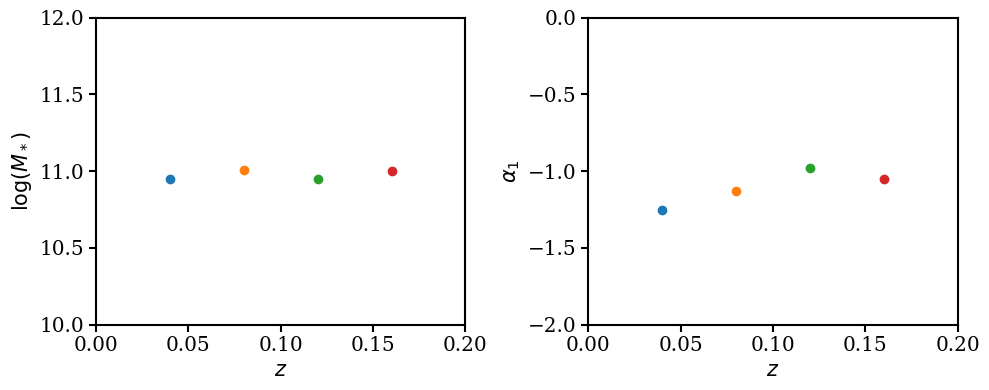

In [13]:
fig = plt.figure(figsize=(10,4))

for i, zmin, zmax in zip(range(4), zmins, zmaxs):
    plt.subplot(1,2,1)
    plt.scatter(zmin + (zmax-zmin)/2. + 0.01, logM_emcee[i], c='C%i' % i)
    
    plt.xlabel(r'$z$', fontsize=15)
    plt.xlim(0., 0.2)
    plt.ylabel(r'$\log (M_*)$', fontsize=15)
    plt.ylim(10., 12.)

    plt.subplot(1,2,2)
    plt.scatter(zmin + (zmax-zmin)/2. + 0.01, alpha1_emcee[i], c='C%i' % i)
    plt.xlabel(r'$z$', fontsize=15)
    plt.xlim(0., 0.2)
    plt.ylabel(r'$\alpha_1$', fontsize=15)
    plt.ylim(-2., 0.)

fig.tight_layout()
plt.show()

In [14]:
def logM_z(z, a0, a1):
    return a0 + a1 * z

def alpha1_z(z, a2, a3):
    return a2 + a3 * z


In [15]:
popt_logM, _ = curve_fit(logM_z, zmins + (zmaxs - zmins)/2., logM_emcee)
popt_alpha1, _ = curve_fit(alpha1_z, zmins + (zmaxs - zmins)/2., alpha1_emcee)

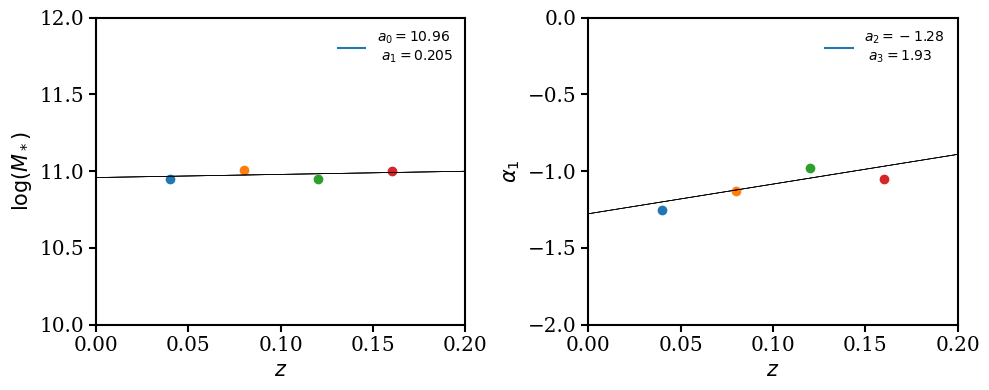

In [16]:
fig = plt.figure(figsize=(10,4))

z_lin = np.linspace(0, 0.2, 200)

for i, zmin, zmax in zip(range(4), zmins, zmaxs):
    plt.subplot(1,2,1)
    plt.scatter(zmin + (zmax-zmin)/2. + 0.01, logM_emcee[i], c='C%i' % i)
    plt.plot(z_lin, logM_z(z_lin, popt_logM[0], popt_logM[1]), c='black', alpha=0.8, linewidth=0.5)
    if i == 0:
        plt.plot([], [], label= f"$a_0 = {round(popt_logM[0],2)}$ \n $a_1 = {round(popt_logM[1],3)}$")
    
    plt.xlabel(r'$z$', fontsize=15)
    plt.xlim(0., 0.2)
    plt.ylabel(r'$\log (M_*)$', fontsize=15)
    plt.ylim(10., 12.)
    plt.legend(loc='best')

    plt.subplot(1,2,2)
    plt.scatter(zmin + (zmax-zmin)/2. + 0.01, alpha1_emcee[i], c='C%i' % i)
    plt.plot(z_lin, alpha1_z(z_lin, popt_alpha1[0], popt_alpha1[1]), c='black', alpha=0.8, linewidth=0.5)
    if i == 0:
        plt.plot([], [], label= f"$a_2 = {round(popt_alpha1[0],2)}$ \n $a_3 = {round(popt_alpha1[1],2)}$")
    
    plt.xlabel(r'$z$', fontsize=15)
    plt.xlim(0., 0.2)
    plt.ylabel(r'$\alpha_1$', fontsize=15)
    plt.ylim(-2., 0.)
    plt.legend(loc='best')

fig.tight_layout()
plt.show()

In [17]:
popt_logM, popt_alpha1

(array([10.95786444,  0.20488199]), array([-1.27799601,  1.93370693]))